## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.25, 0.5, 0.75, 0.9]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for dropout in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with dropout = %.6f" % (dropout))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropout)
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-dropout-%s" % str(dropout)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with dropout = 0.250000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
____________________________________________________

50000/50000 [==============================] - 2s 31us/step - loss: 1.4685 - acc: 0.4705 - val_loss: 1.4340 - val_acc: 0.4920
Epoch 43/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.4641 - acc: 0.4718 - val_loss: 1.4168 - val_acc: 0.4971
Epoch 44/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.4646 - acc: 0.4712 - val_loss: 1.4230 - val_acc: 0.4849
Epoch 45/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.4607 - acc: 0.4761 - val_loss: 1.4365 - val_acc: 0.4891
Epoch 46/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.4553 - acc: 0.4769 - val_loss: 1.4276 - val_acc: 0.4911
Epoch 47/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.4588 - acc: 0.4751 - val_loss: 1.4388 - val_acc: 0.4958
Epoch 48/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.4517 - acc: 0.4795 - val_loss: 1.4173 - val_acc: 0.5001
Epoch 49/50
50000/50000 [=====================

Epoch 41/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.9693 - acc: 0.2565 - val_loss: 2.1023 - val_acc: 0.2345
Epoch 42/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9696 - acc: 0.2521 - val_loss: 2.0662 - val_acc: 0.2352
Epoch 43/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9651 - acc: 0.2563 - val_loss: 2.0522 - val_acc: 0.2417
Epoch 44/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9658 - acc: 0.2556 - val_loss: 1.9904 - val_acc: 0.2642
Epoch 45/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.9594 - acc: 0.2604 - val_loss: 2.0960 - val_acc: 0.2378
Epoch 46/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.9610 - acc: 0.2575 - val_loss: 1.9910 - val_acc: 0.2704
Epoch 47/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.9603 - acc: 0.2578 - val_loss: 2.0686 - val_acc: 0.2284
Epoch 48/50
50000/50000 [=========

Epoch 40/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.3027 - acc: 0.0979 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 41/50
50000/50000 [==============================] - 2s 33us/step - loss: 2.3027 - acc: 0.0988 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 42/50
50000/50000 [==============================] - 2s 30us/step - loss: 2.3027 - acc: 0.0986 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 43/50
50000/50000 [==============================] - 2s 30us/step - loss: 2.3026 - acc: 0.0969 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 44/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0977 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0981 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3026 - acc: 0.0982 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 47/50
50000/50000 [=========

50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0965 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 39/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.3027 - acc: 0.0974 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 40/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.3027 - acc: 0.0991 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 41/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0990 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 42/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0973 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 43/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 44/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3027 - acc: 0.0971 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 45/50
50000/50000 [=====================

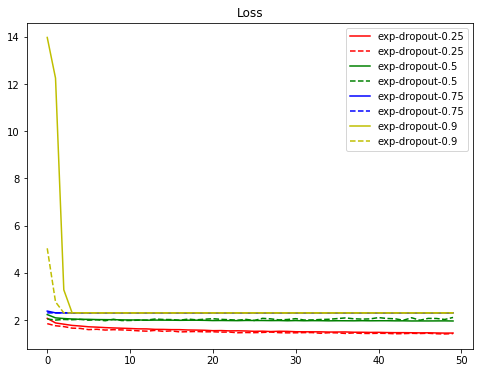

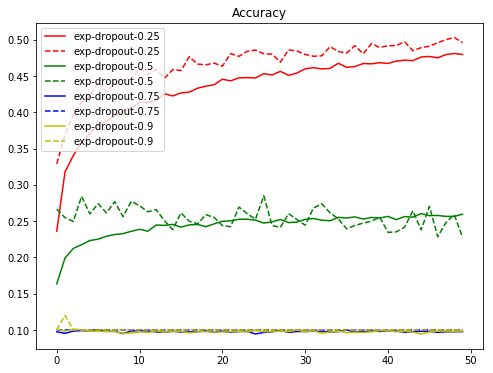

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()